In [156]:
import os
import sys
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from six.moves import urllib
from tensorflow.python.framework import ops
ops.reset_default_graph()


# Start a graph session
sess = tf.Session()

# Set model parameters
batch_size = 128
data_dir = 'temp'
output_every = 50
generations = 20000
eval_every = 500
image_height = 32
image_width = 32
crop_height = 24
crop_width = 24
num_channels = 3
num_targets = 10
extract_folder = 'cifar-10-batches-bin'

In [157]:
# Exponential Learning Rate Decay Params
learning_rate = 0.1
lr_decay = 0.1
num_gens_to_wait = 250.


In [158]:
#extract moedl parameters
image_vec_length = image_height * image_width * num_channels
record_length = 1 + image_vec_length
#(+1 for the 0-9 label)


In [159]:
#load data
data_dir = 'temp'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
cifar10_url = 'http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'



In [160]:
# Check if file exists, otherwise download it
data_file = os.path.join(data_dir, 'cifar-10-binary.tar.gz')
if os.path.isfile(data_file):
    pass
else:
    # Download file
    def progress(block_num, block_size, total_size):
        progress_info = [cifar10_url, float(block_num * block_size) / float(total_size) * 100.0]
        print('\r Downloading {} - {:.2f}%'.format(*progress_info), end="")
    filepath, _ = urllib.request.urlretrieve(cifar10_url, data_file, progress)
    # Extract file
    tarfile.open(filepath, 'r:gz').extractall(data_dir)
    

In [161]:
#Define CIFAR reader
def read_cifar_files(filename_queue, distort_images = True):
    reader = tf.FixedLengthRecordReader(record_bytes = record_length)
    key, record_string = reader.read(filename_queue)
    record_bytes = tf.decode_raw(record_string, tf.uint8)
    image_label = tf.cast(tf.slice(record_bytes, [0], [1]), tf.int32)
    
    #Extract image
    image_extracted = tf.reshape(tf.slice(record_bytes, [1], [image_vec_length]), [num_channels, image_height, image_width])
    
    #Reshape image
    image_uint8image = tf.transpose(image_extracted, [1, 2, 0])
    reshaped_image = tf.cast(image_uint8image, tf.float32)
    
    #Randomly Crop image
    final_image = tf.image.resize_image_with_crop_or_pad(reshaped_image, crop_width, crop_height)
    
    if distort_images:
        #Randomly flip the image horozontally, change the brightness and contrast
        final_image = tf.image.random_flip_left_right(final_image)
        final_image = tf.image.random_brightness(final_image, max_delta = 63)
        final_image = tf.image.random_contrast(final_image, lower = 0.2, upper = 1.8)
        
    #Normalize whitening 
    final_image = tf.image.per_image_standardization(final_image)
    return(final_image, image_label)

#Create a CIFAR image pipeline from reader
def input_pipeline(batch_size, train_logical = True):
    if train_logical:
        files = [os.path.join(data_dir, extract_folder, 'data_batch_{}.bin'.format(i)) for i in range(1,6)]
    else:
        files = [os.path.join(data_dir, extract_folder, 'test_batch.bin')]
    filename_queue = tf.train.string_input_producer(files)
    image, label = read_cifar_files(filename_queue)
    # min_after_dequeue defines how big a buffer we will randomly sample
    #   from -- bigger means better shuffling but slower start up and more
    #   memory used.
    # capacity must be larger than min_after_dequeue and the amount larger
    #   determines the maximum we will prefetch.  Recommendation:
    #   min_after_dequeue + (num_threads + a small safety margin) * batch_size
    min_after_dequeue = 5000
    capacity = min_after_dequeue + 3 * batch_size
    example_batch, label_batch = tf.train.shuffle_batch([image, label], batch_size = batch_size, capacity = capacity, min_after_dequeue = min_after_dequeue)
    return(example_batch, label_batch)



    
    

In [162]:
# Define the model architecture, this will return logits from images
def cifar_cnn_model(input_images, batch_size, train_logical=True ):
    def truncated_normal_var(name, shape, dtype):
        return (tf.get_variable(name = name, shape = shape, dtype = dtype, initializer = tf.truncated_normal_initializer(stddev = 0.05)))
    def zero_var(name, shape, dtype):
        return(tf.get_variable(name = name, shape = shape, dtype = dtype, initializer = tf.constant_initializer(0.0)))
    
    #First Convolutional Layer
    with tf.variable_scope('conv1') as scope:
        #Conv_kernel is 5x5 for all 3 colors and we will create 64 features
        conv1_kernel = truncated_normal_var(name = 'conv_kernel1', shape = [5, 5, 3, 64], dtype = tf.float32)
        #We convolve across the image with a stride size of 1
        conv1 = tf.nn.conv2d(input_images, conv1_kernel, [1, 1, 1, 1], padding = 'SAME')
        #Initialize and add the bias term
        conv1_bias = zero_var(name = 'conv_bias1', shape = [64], dtype = tf.float32)
        conv1_add_bias = tf.nn.bias_add(conv1, conv1_bias)
        #ReLU element wise
        relu_conv1 = tf.nn.relu(conv1_add_bias)
        
    #Max Pooling
    pool1 = tf.nn.max_pool(relu_conv1, ksize = [1, 3, 3, 1], strides = [1, 2, 2, 1], padding = 'SAME', name = 'pool_layer1')
    
    #Local Response Normalization (parameters from paper)
    #paper: http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks
    norm1 = tf.nn.lrn(pool1, depth_radius = 5, bias = 2.0, alpha = 1e-3, beta = 0.75, name = 'norm1')
    
    #Second Convolutional Layer
    with tf.variable_scope('conv2') as scope:
        #Conv kernel is 5x5, across all prior 64 features and we create 64 more features
        conv2_kernel = truncated_normal_var(name = 'conv_kernel2', shape = [5, 5, 64, 64], dtype = tf.float32)
        #Convolve filter across prior output with stride size of 1
        conv2 = tf.nn.conv2d(norm1, conv2_kernel, [1, 1, 1, 1], padding = 'SAME')
        #Initialize and add the bias
        conv2_bias = zero_var(name = 'conv_bias2', shape = [64], dtype = tf.float32)
        conv2_add_bias = tf.nn.bias_add(conv2, conv2_bias)
        #ReLU element wise
        relu_conv2 = tf.nn.relu(conv2_add_bias)
        
    #Max pooling
    pool2 = tf.nn.max_pool(relu_conv2, ksize = [1, 3, 3, 1], strides = [1, 2, 2, 1], padding = 'SAME', name = 'pool_layer2')
    
    #Local Response Normalization (parameters from paper)
    norm2 = tf.nn.lrn(pool2, depth_radius = 5, bias = 2.0, alpha = 1e-3, beta = 0.75, name = 'norm2')
    
    #Reshape output into a single matrix for multiplication for the fully connected layers
    reshaped_output = tf.reshape(norm2, [batch_size, -1])
    reshaped_dim = reshaped_output.get_shape()[1].value
    
    #First Fully Connected Layer
    with tf.variable_scope('full1') as scope:
        #Fully connected layer will have 384 outputs.
        full_weight1 = truncated_normal_var(name = 'full_mult1', shape = [reshaped_dim, 384], dtype = tf.float32)
        full_bias1 = zero_var(name = 'full_bias1', shape = [384], dtype = tf.float32)
        full_layer1 = tf.nn.relu(tf.add(tf.matmul(reshaped_output, full_weight1), full_bias1))
        
    #Second Fully Connected Layer
    with tf.variable_scope('full2') as scope:
        #Second fully connected layer has 192 outputs
        full_weight2 = truncated_normal_var(name = 'full_mult2', shape = [384, 192], dtype = tf.float32)
        full_bias2 = zero_var(name = 'full_bias2', shape = [192], dtype = tf.float32)
        full_layer2 = tf.nn.relu(tf.add(tf.matmul(full_layer1, full_weight2), full_bias2))
        
    #Final Fully Connected Layer -> 10 categories for output (num_targets)
    with tf.variable_scope('full3') as scope:
        full_weight3 = truncated_normal_var(name = 'full_mult3', shape = [192, num_targets], dtype = tf.float32)
        full_bias3 = zero_var(name = 'full_bias3', shape = [num_targets], dtype = tf.float32)
        final_output = tf.add(tf.matmul(full_layer2, full_weight3), full_bias3)
        
    return(final_output)



        


In [163]:
#Loss function
def cifar_loss(logits, targets):
    #Get rid of extra dimensions and cast targets into integers
    targets = tf.squeeze(tf.cast(targets, tf.int32))
    #Calculate cross entropy from logits and targets
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = targets)
    #Take the average loss across batch size
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name = 'cross_entropy')
    return(cross_entropy_mean)



In [164]:
#Train step
def train_step(loss_value, generation_num):
    #Our learning rate is an exponential decay after we wait a fair number of generations
    model_learning_rate = tf.train.exponential_decay(learning_rate, generation_num, num_gens_to_wait, lr_decay, staircase = True)
    #Create optimizer
    my_optimizer = tf.train.GradientDescentOptimizer(model_learning_rate)
    #Initialize train step
    train_step = my_optimizer.minimize(loss_value)
    return(train_step)


In [165]:
#Accuracy function
def accuracy_of_batch(logits, targets):
    #Make sure targets are integers and drop extra dimensions
    targets = tf.squeeze(tf.cast(targets, tf.int32))
    #Get predicted values by finding which logit is the greatest
    batch_predictions = tf.cast(tf.argmax(logits,1), tf.int32)
    #Check if they are equal across the batch
    predicted_correctly = tf.equal(batch_predictions, targets)
    #Average the 1's and 0's (True's and False's) across the batch size
    accuracy = tf.reduce_mean(tf.cast(predicted_correctly, tf.float32))
    return(accuracy)

In [166]:
#Get data
print('Getting/Transforming Data.')
#Initialize the data pipeline
images, targets = input_pipeline(batch_size, train_logical = True)
#Get batch test images and targets from pipline
test_images, test_targets = input_pipeline(batch_size, train_logical = False)


Getting/Transforming Data.


In [167]:
#Declare Model
print('Create the CIFAR10 Model')
with tf.variable_scope('model_definition') as scope:
    #Decthe traning network model
    model_output = cifar_cnn_model(images, batch_size)
    # This is very important!!!  We must set the scope to REUSE the variables,
    #  otherwise, when we set the test network model, it will create new random
    #  variables.  Otherwise we get random evaluations on the test batches.
    scope.reuse_variables()
    test_output = cifar_cnn_model(test_images, batch_size)
    
#Declare accuracy function
print('Declare Loss function.')
loss = cifar_loss(model_output, targets)

#Create accuracy function
accuracy = accuracy_of_batch(test_output, test_targets)

#Create training operations
print('Create the Training Operation.')
generation_num = tf.Variable(0, trainable = False)
train_op = train_step(loss, generation_num)

#Initialize Variables
print('Initialize the Variables.')
init = tf.global_variables_initializer()
sess.run(init)

#Initialize queue(This queue will feed into the model, so no placeholders necessary)
tf.train.start_queue_runners(sess = sess)



Create the CIFAR10 Model
Declare Loss function.
Create the Training Operation.
Initialize the Variables.


[<Thread(QueueRunnerThread-input_producer-input_producer/input_producer_EnqueueMany, started daemon 123145348001792)>,
 <Thread(QueueRunnerThread-shuffle_batch/random_shuffle_queue-shuffle_batch/random_shuffle_queue_enqueue, started daemon 123145353256960)>,
 <Thread(QueueRunnerThread-input_producer_1-input_producer_1/input_producer_1_EnqueueMany, started daemon 123145358512128)>,
 <Thread(QueueRunnerThread-shuffle_batch_1/random_shuffle_queue-shuffle_batch_1/random_shuffle_queue_enqueue, started daemon 123145363767296)>]

Starting Training
Generation 50: Loss = 1.84506
Generation 100: Loss = 1.93712
Generation 150: Loss = 1.54756
Generation 200: Loss = 1.72710
Generation 250: Loss = 1.57010
Generation 300: Loss = 1.77831
Generation 350: Loss = 1.58394
Generation 400: Loss = 1.56061
Generation 450: Loss = 1.47780
Generation 500: Loss = 1.39571
---Test Accuracy = 41.41%.
Generation 550: Loss = 1.35071
Generation 600: Loss = 1.44525
Generation 650: Loss = 1.33244
Generation 700: Loss = 1.29222
Generation 750: Loss = 1.24531
Generation 800: Loss = 1.13471
Generation 850: Loss = 1.28628
Generation 900: Loss = 1.00101
Generation 950: Loss = 1.19030
Generation 1000: Loss = 1.34687
---Test Accuracy = 57.81%.
Generation 1050: Loss = 1.06176
Generation 1100: Loss = 1.26375
Generation 1150: Loss = 0.95626
Generation 1200: Loss = 0.95690
Generation 1250: Loss = 0.97988
Generation 1300: Loss = 0.94837
Generation 1350: Loss = 0.88046
Generation 1400: Loss = 1.10863
Generation 1450: Loss = 1.07176
Generation 1500: Los

Generation 11850: Loss = 0.15119
Generation 11900: Loss = 0.16948
Generation 11950: Loss = 0.10518
Generation 12000: Loss = 0.20890
---Test Accuracy = 72.66%.
Generation 12050: Loss = 0.09000
Generation 12100: Loss = 0.11577
Generation 12150: Loss = 0.14447
Generation 12200: Loss = 0.08613
Generation 12250: Loss = 0.09906
Generation 12300: Loss = 0.16770
Generation 12350: Loss = 0.20728
Generation 12400: Loss = 0.35119
Generation 12450: Loss = 0.06953
Generation 12500: Loss = 0.14284
---Test Accuracy = 76.56%.
Generation 12550: Loss = 0.15000
Generation 12600: Loss = 0.18086
Generation 12650: Loss = 0.14314
Generation 12700: Loss = 0.19751
Generation 12750: Loss = 0.20451
Generation 12800: Loss = 0.20154
Generation 12850: Loss = 0.11304
Generation 12900: Loss = 0.08391
Generation 12950: Loss = 0.18737
Generation 13000: Loss = 0.23068
---Test Accuracy = 78.91%.
Generation 13050: Loss = 0.09511
Generation 13100: Loss = 0.08809
Generation 13150: Loss = 0.15476
Generation 13200: Loss = 0.0

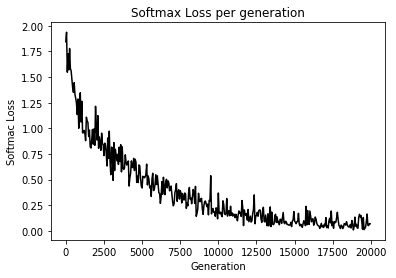

<function matplotlib.pyplot.show(*args, **kw)>

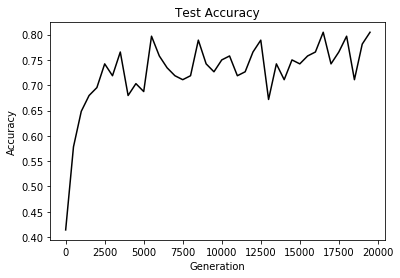

In [169]:
#Train CIFAR Model
print('Starting Training')
train_loss = []
test_accuracy = []
for i in range(generations):
    _, loss_value = sess.run([train_op, loss])
    
    if (i + 1) % output_every == 0:
        train_loss.append(loss_value)
        output = 'Generation {}: Loss = {:.5f}'.format((i + 1), loss_value)
        print(output)
        
    if (i + 1) % eval_every == 0:
        [temp_accuracy] = sess.run([accuracy])
        test_accuracy.append(temp_accuracy)
        acc_output = '---Test Accuracy = {:.2f}%.'.format(100.*temp_accuracy)
        print(acc_output)
        
        
        

# Print loss and accuracy
# Matlotlib code to plot the loss and accuracies
eval_indices = range(0, generations, eval_every)
output_indices = range(0, generations, output_every)

#Plot loss over time
plt.plot(output_indices, train_loss, 'k-')
plt.title('Softmax Loss per generation')
plt.xlabel('Generation')
plt.ylabel('Softmac Loss')
plt.show()

#Plot loss over time
plt.plot(eval_indices, test_accuracy, 'k-')
plt.title('Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.show


In [1]:
def add_to_life_universe_everything(x):
    answer = 42
    from IPython.core.debugger import Tracer; Tracer()() 
    answer += x
    
    return answer

add_to_life_universe_everything(12)

/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `Tracer` is deprecated since version 5.1, directly use `IPython.core.debugger.Pdb.set_trace()`
  This is separate from the ipykernel package so we can avoid doing imports until


> <ipython-input-1-7f9480731fe8>(4)add_to_life_universe_everything()
      2     answer = 42
      3     from IPython.core.debugger import Tracer; Tracer()()
----> 4     answer += x
      5 
      6     return answer

ipdb> c


54

In [ ]:
def add_to_life_universe_everything(x):
    answer = 42
    import pdb; pdb.set_trace()
    answer += x
    
    return answer

add_to_life_universe_everything(12)

> <ipython-input-2-350461409232>(4)add_to_life_universe_everything()
-> answer += x
